In [1]:
import os
import sys
import subprocess
from pathlib import Path

repo_root = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()

sys.path.append(repo_root)

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import pickle

from matplotlib import pyplot as plt

import params, utils
from modules import helpers, training
from modules.nn import mlp, pca

In [3]:
import importlib

importlib.reload(params)
importlib.reload(utils)

importlib.reload(training)

importlib.reload(mlp)
importlib.reload(pca)

<module 'modules.nn.pca' from '/Users/vinhtran/Data/MIT Classes/Spring 2025/8.13/mit-jlab-sp25/modules/nn/pca.py'>

In [4]:
helpers.set_plot_configs()

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [5]:
MC_dir = '../HiggsTo4L/MC/'
data_dir = '../HiggsTo4L/data/'

In [6]:
four_leptons_data = utils.FourLeptonsData()
four_leptons_nn = utils.FourLeptonNN()

In [7]:
print('Higgs:')
mc_higgs_all_data = four_leptons_data.apply_basic_cuts(
    [
        four_leptons_data.read_data(file) for file in [
            MC_dir + 'higgs2011.csv',
            MC_dir + 'higgs2012.csv'
        ]
    ],
    lepton_pT_cuts=None,lepton_eta_cuts=None,
    heavier_Z_cuts=None,lighter_Z_cuts=None,
    show_cut_info=True
)

print('ZZ:')
mc_zz_all_data = four_leptons_data.apply_basic_cuts(
    [ 
        four_leptons_data.read_data(file) for file in [
            MC_dir + 'zzto4mu2011.csv',
            MC_dir + 'zzto2mu2e2011.csv',
            MC_dir + 'zzto4e2011.csv',

            MC_dir + 'zzto4mu2012.csv',
            MC_dir + 'zzto2mu2e2012.csv',
            MC_dir + 'zzto4e2012.csv',
        ]
    ],
    lepton_pT_cuts=None,lepton_eta_cuts=None,
    heavier_Z_cuts=None,lighter_Z_cuts=None,
    show_cut_info=True
)

print('Drell-Yan:')
mc_dy_all_data = four_leptons_data.apply_basic_cuts(
    [
        four_leptons_data.read_data(file) for file in [
            MC_dir + 'dy1050_2011.csv',
            MC_dir + 'dy50_2011.csv',
            MC_dir + 'dy1050_2012.csv',
            MC_dir + 'dy50_2012.csv'
        ]
    ],
    lepton_pT_cuts=None,lepton_eta_cuts=None,
    heavier_Z_cuts=None,lighter_Z_cuts=None,
    show_cut_info=True
)

print('tt:')
mc_tt_all_data = four_leptons_data.apply_basic_cuts(
    [
        four_leptons_data.read_data(file) for file in [
            MC_dir + 'ttbar2011.csv',
            MC_dir + 'ttbar2012.csv'
        ]
    ],
    lepton_pT_cuts=None,lepton_eta_cuts=None,
    heavier_Z_cuts=None,lighter_Z_cuts=None,
    show_cut_info=True
)

Higgs:
 Conservation cut: 50542 events passed out of 52248 (97%)
 Conservation cut: 39353 events passed out of 40530 (97%)
ZZ:
 Conservation cut: 207439 events passed out of 209504 (99%)
 Conservation cut: 152367 events passed out of 155454 (98%)
 Conservation cut: 140811 events passed out of 144999 (97%)
 Conservation cut: 182153 events passed out of 183843 (99%)
 Conservation cut: 121906 events passed out of 124496 (98%)
 Conservation cut: 104065 events passed out of 107496 (97%)
Drell-Yan:
 Conservation cut: 29 events passed out of 59 (49%)
 Conservation cut: 342 events passed out of 507 (67%)
 Conservation cut: 14 events passed out of 42 (33%)
 Conservation cut: 148 events passed out of 228 (65%)
tt:
 Conservation cut: 171 events passed out of 637 (27%)
 Conservation cut: 5 events passed out of 24 (21%)


In [8]:
bins = np.linspace(50,200,51)
bin_centers = (bins[1:] + bins[:-1]) / 2
bin_width = bins[1] - bins[0]

higgs_hist = four_leptons_data.get_histogram(mc_higgs_all_data, params.scales_higgs, 'm4l', bins) 
zz_hist = four_leptons_data.get_histogram(mc_zz_all_data, params.scales_zz, 'm4l', bins)
dy_hist = four_leptons_data.get_histogram(mc_dy_all_data, params.scales_dy, 'm4l', bins)
tt_hist = four_leptons_data.get_histogram(mc_tt_all_data, params.scales_tt, 'm4l', bins)

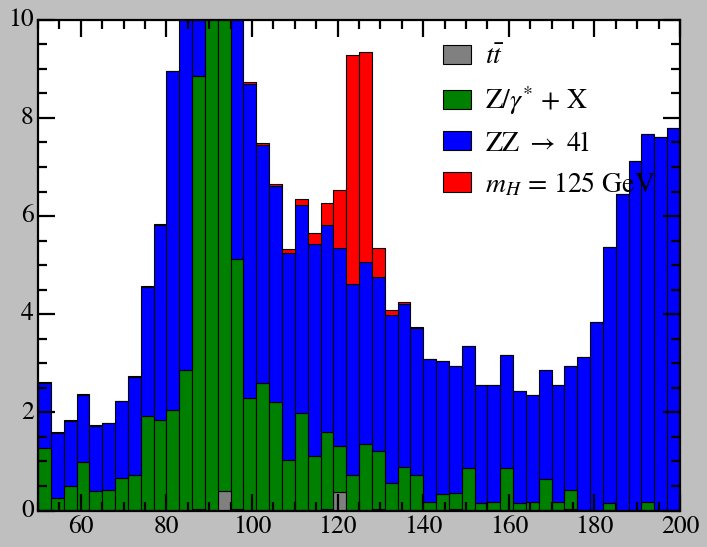

In [9]:
fig, ax = plt.subplots(figsize=(9,7))

stack = ax.bar(bin_centers, tt_hist, align='center', width=bin_width, label=r'$t\bar{t}$', color='grey')
stack = ax.bar(bin_centers, dy_hist, align='center', width=bin_width, label=r'Z/$\gamma^{*}$ + X', color='green', bottom=tt_hist)
stack = ax.bar(bin_centers, zz_hist, align='center', width=bin_width, label=r'ZZ $\rightarrow$ 4l', color='blue', bottom=tt_hist+dy_hist)
stack = ax.bar(bin_centers, higgs_hist, align='center', width=bin_width, label=r'$m_{H}$ = 125 GeV', color='red', bottom=tt_hist+dy_hist+zz_hist)

ax.legend(loc='upper right', frameon=False, ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5)

ax.set_xlim(50,200)
ax.set_ylim(0, 10)

plt.tight_layout()
plt.show()

In [10]:
class FourLeptonsPCA(pca.PCA):
    def __init__(self,
                 all_data,data_labels,
                 fields,field_indices):
        self.all_data = all_data
        self.event_nums = [len(data) for data in all_data]
        self.all_labels = [np.array([label]*len(data)) for label,data in zip(data_labels,all_data)]

        self.fields = fields
        self.field_indices = [field_indices[field] for field in fields]

    def _subsample(self, data, label, n):
        idx = np.random.choice(len(data), n, replace=False)
        return data[idx], label[idx]
    
    def get_pca(self):
        X = []
        Y = []

        for data,label in zip(self.all_data,self.all_labels):
            reduced_data, reduced_label = self._subsample(data,label,min(self.event_nums))
            X.append(reduced_data)
            Y.append(reduced_label)

        X = np.concatenate(X)
        Y = np.concatenate(Y)

        X = torch.from_numpy(X)

        X_norm, X_mean, X_std = self._standardize(X)
        X_pca, V = self._perform_pca(X_norm)

        return X_pca.numpy()[Y==1], X_pca.numpy()[Y==0]

In [11]:
mc_all_data = mc_higgs_all_data + mc_zz_all_data
fields = [
    'E1', 'px1', 'py1', 'pz1',
    'E2', 'px2', 'py2', 'pz2',
    'E3', 'px3', 'py3', 'pz3',
    'E4', 'px4', 'py4', 'pz4',
]

mc_all_pca = FourLeptonsPCA(all_data=mc_all_data,
                            data_labels=[1]*len(mc_higgs_all_data) + [0]*len(mc_zz_all_data),
                            fields=fields,
                            field_indices=params.field_indices)
higgs_pca, zz_pca = mc_all_pca.get_pca()

In [12]:
if False:
    for pca_idx in range(16):
        print('PC', pca_idx+1)

        bins = np.linspace(-3,3,101)
        bin_centers = (bins[1:] + bins[:-1]) / 2
        bin_width = bins[1] - bins[0]

        higgs_hist, _, _ = plt.hist(higgs_pca[:,pca_idx], bins=bins, histtype='step', color='red',density=True, lw=1)
        # plt.plot(bin_centers, np.cumsum(higgs_hist) * bin_width, color='red', lw=2, ls='--')

        zz_hist, _, _ = plt.hist(zz_pca[:,pca_idx], bins=bins, histtype='step', color='blue',density=True, lw=1)
        # plt.plot(bin_centers, np.cumsum(zz_hist) * bin_width, color='blue', lw=2, ls='--')

        plt.xlim(-3,3)
        plt.ylim(0,0.5)

        plt.tight_layout()
        plt.show()

In [13]:
all_higgs_and_zz_data = [
    four_leptons_data.read_data(file) for file in [
        MC_dir + 'higgs2011.csv',
        MC_dir + 'higgs2012.csv',

        MC_dir + 'zzto4mu2011.csv',
        MC_dir + 'zzto2mu2e2011.csv',
        MC_dir + 'zzto4e2011.csv',
        MC_dir + 'zzto4mu2012.csv',
        MC_dir + 'zzto2mu2e2012.csv',
        MC_dir + 'zzto4e2012.csv',

        MC_dir + 'dy1050_2011.csv',
        MC_dir + 'dy50_2011.csv',
        MC_dir + 'dy1050_2012.csv',
        MC_dir + 'dy50_2012.csv',
    ]
]

all_higgs_and_zz_data = four_leptons_data.apply_basic_cuts(
    all_higgs_and_zz_data,
    lepton_pT_cuts=None,lepton_eta_cuts=None,
    heavier_Z_cuts=None,lighter_Z_cuts=None,
    show_cut_info=False
)

fields = [
    'px1','py1',
    'px2','py2',
    'px3','py3',
    'px4','py4',
]

X_higgs_and_zz, Y_higgs_and_zz = four_leptons_nn.get_training_data(
    all_data = all_higgs_and_zz_data,
    data_labels = [1]*2 + [0]*10,
    fields = fields,
)
higgs_and_zz_train_loader, higgs_and_zz_val_loader, N_data, N_train, N_val = four_leptons_nn.get_training_dataloaders(
    X_higgs_and_zz, Y_higgs_and_zz,
    train_ratio=0.8,
    batch_size=2048,
    num_workers=8,
    seed=42,
)

In [14]:
N_data

179790

In [15]:
model = mlp.MLP(
    input_dim=8,
    hidden_dims=[256, 64, 16, 4],
    output_dim=1,
    dropout=0.0,
    activation=nn.ReLU(),
    norm=nn.BatchNorm1d,
    last_activation=nn.Sigmoid(),
)

In [16]:
trainer = training.SupervisedTraining(
    model=model,
    train_loader=higgs_and_zz_train_loader,
    val_loader=higgs_and_zz_val_loader,
    num_epochs=50,
    lr=5e-4,
    criterion=nn.BCELoss(),
    optimizer=optim.Adam,
    scheduler=optim.lr_scheduler.CosineAnnealingLR,
    scheduler_params={'T_max': 50},
    is_classification=True,
    num_classes=2,
    device='mps',
)

In [17]:
trainer.train(save_training_stats_every=5, save_model_every=None, outpath='training_result/MLP_reduced/')

Training:   2%|▏         | 1/50 [00:12<09:55, 12.16s/it]

Epoch 1/50 - Train Loss: 0.60467 - Val Loss: 0.58116


Training:  10%|█         | 5/50 [00:54<08:04, 10.77s/it]

Epoch 5/50 - Train Loss: 0.42621 - Val Loss: 0.41523


Training:  20%|██        | 10/50 [01:46<06:53, 10.33s/it]

Epoch 10/50 - Train Loss: 0.36731 - Val Loss: 0.36476


Training:  30%|███       | 15/50 [02:36<05:52, 10.08s/it]

Epoch 15/50 - Train Loss: 0.34153 - Val Loss: 0.34046


Training:  40%|████      | 20/50 [03:26<05:00, 10.01s/it]

Epoch 20/50 - Train Loss: 0.32804 - Val Loss: 0.33304


Training:  50%|█████     | 25/50 [04:17<04:11, 10.07s/it]

Epoch 25/50 - Train Loss: 0.31989 - Val Loss: 0.32186


Training:  60%|██████    | 30/50 [05:08<03:22, 10.14s/it]

Epoch 30/50 - Train Loss: 0.31788 - Val Loss: 0.31898


Training:  70%|███████   | 35/50 [05:59<02:33, 10.24s/it]

Epoch 35/50 - Train Loss: 0.31185 - Val Loss: 0.31968


Training:  80%|████████  | 40/50 [06:49<01:41, 10.20s/it]

Epoch 40/50 - Train Loss: 0.31280 - Val Loss: 0.31475


Training:  90%|█████████ | 45/50 [07:41<00:51, 10.31s/it]

Epoch 45/50 - Train Loss: 0.30774 - Val Loss: 0.31922


Training: 100%|██████████| 50/50 [08:32<00:00, 10.24s/it]

Epoch 50/50 - Train Loss: 0.31184 - Val Loss: 0.31456


In [18]:
training_stats = pickle.load(open('training_result/MLP_reduced/training_stats.pkl', 'rb'))

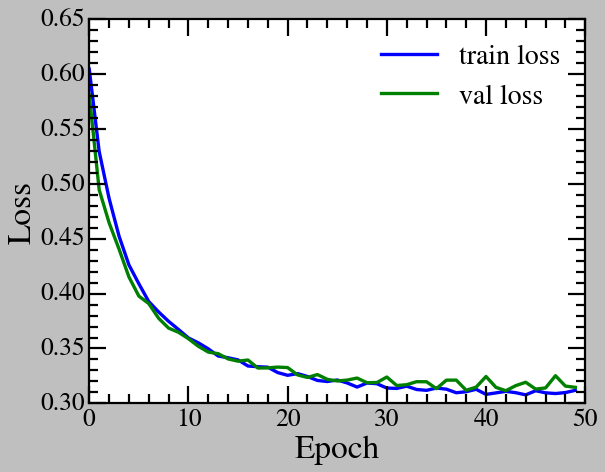

In [19]:
plt.plot(training_stats['train_losses'], label='train loss')
plt.plot(training_stats['val_losses'], label='val loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')

#plt.yscale('log')

plt.legend()
plt.show()

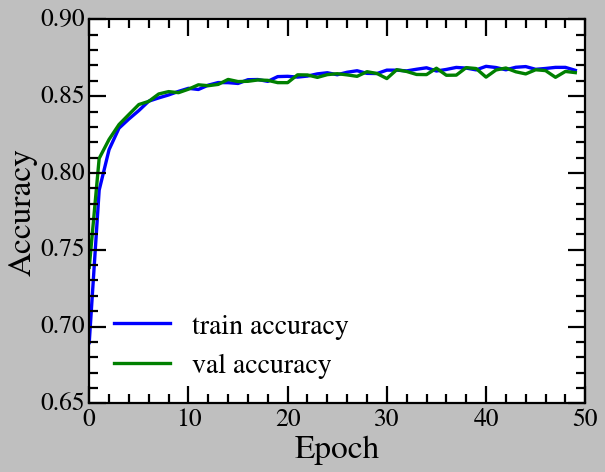

In [20]:
plt.plot(training_stats['train_accuracies'], label='train accuracy')
plt.plot(training_stats['val_accuracies'], label='val accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()

plt.show()

In [21]:
best_model_idx = np.argmin(training_stats['val_losses'])

print('Best detection rate:', training_stats['val_P_detections'][best_model_idx])
print('Best false alarm rate:', training_stats['val_P_false_alarms'][best_model_idx])

Best detection rate: 0.8935999340481229
Best false alarm rate: 0.1569518902235561


In [22]:
best_state_dict = torch.load('training_result/MLP_reduced/model/best.pth')['model_state_dict']
model.load_state_dict(best_state_dict)

/var/folders/_n/k8j9__0s4x1b10rq7h7zj1bc0000gq/T/ipykernel_94960/1989645927.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_state_dict = torch.load('training_result

<All keys matched successfully>

In [23]:
nn_higgs_and_zz_data = four_leptons_nn.apply_nn_cut(
    all_higgs_and_zz_data, fields=fields, 
    model=model, batch_size=2048, num_workers=8,
    threshold=0.5, device='mps'
)

nn_higgs_data = nn_higgs_and_zz_data[:2]
nn_zz_data = nn_higgs_and_zz_data[2:8]
nn_dy_data = nn_higgs_and_zz_data[8:]

In [24]:
bins = np.linspace(50,200,51)
bin_centers = (bins[1:] + bins[:-1]) / 2
bin_width = bins[1] - bins[0]

nn_higgs_hist = four_leptons_data.get_histogram(nn_higgs_data, params.scales_higgs, 'm4l', bins) 
nn_zz_hist = four_leptons_data.get_histogram(nn_zz_data, params.scales_zz, 'm4l', bins)
nn_dy_hist = four_leptons_data.get_histogram(nn_dy_data, params.scales_dy, 'm4l', bins)

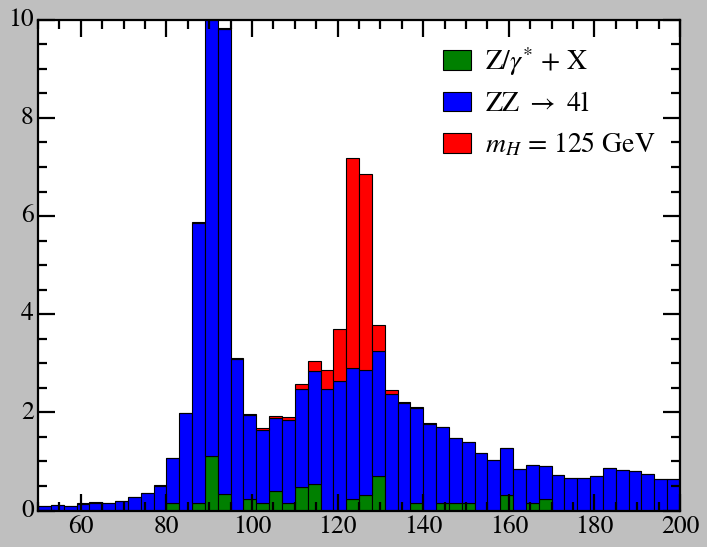

In [25]:
fig, ax = plt.subplots(figsize=(9,7))

stack = ax.bar(bin_centers, nn_dy_hist, align='center', width=bin_width, label=r'Z/$\gamma^{*}$ + X', color='green')
stack = ax.bar(bin_centers, nn_zz_hist, align='center', width=bin_width, label=r'ZZ $\rightarrow$ 4l', color='blue',bottom=nn_dy_hist)
stack = ax.bar(bin_centers, nn_higgs_hist, align='center', width=bin_width, label=r'$m_{H}$ = 125 GeV', color='red', bottom=nn_dy_hist+nn_zz_hist)

ax.legend(loc='upper right', frameon=False, ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5)

ax.set_xlim(50,200)
ax.set_ylim(0, 10)

plt.tight_layout()
plt.show()